In [ ]:
!pip install gym
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Run this to install tensorflow version 1.9
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import random
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from collections import deque
print("Gym:", gym.__version__)
print("Tensorflow:", tf.__version__)


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/dtypes.py:513: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/dtypes.py:521: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/tensor_util.py:106: DeprecationWarning: `np.object` is a deprecated ali

Gym: 0.25.2
Tensorflow: 2.2.0


In [ ]:
class QNetwork():
    def __init__(self, state_dim, action_size, tau=0.01):
        tf.compat.v1.reset_default_graph()
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim])
        self.action_in = tf.placeholder(tf.int32, shape=[None])
        self.q_target_in = tf.placeholder(tf.float32, shape=[None])
        self.importance_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)

        self.q_state_local = self.build_model(action_size, "local")
        self.q_state_target = self.build_model(action_size, "target")

        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state_local, action_one_hot), axis=1)
        self.error = self.q_state_action - self.q_target_in
        self.loss = tf.reduce_mean(tf.multiply(tf.square(self.error), self.importance_in))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)

        self.local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="local")
        self.target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target")
        self.updater = tf.group([tf.assign(t, t + tau*(l-t)) for t,l in zip(self.target_vars, self.local_vars)])

    def build_model(self, action_size, scope):
        with tf.variable_scope(scope):
            hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
            q_state = tf.layers.dense(hidden1, action_size, activation=None)
            return q_state

    def update_model(self, session, state, action, q_target, importance):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target, self.importance_in: importance}
        error, _, _ = session.run([self.error, self.optimizer, self.updater], feed_dict=feed)
        return error

    def get_q_state(self, session, state, use_target=False):
        q_state_op = self.q_state_target if use_target else self.q_state_local
        q_state = session.run(q_state_op, feed_dict={self.state_in: state})
        return q_state


In [ ]:
class PrioritizedReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        self.priorities = deque(maxlen=maxlen)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized

    def sample(self, batch_size, priority_scale=1.0):
        sample_size = min(len(self.buffer), batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k=sample_size, weights=sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return map(list, zip(*samples)), importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [ ]:
class DoubleDQNAgent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = PrioritizedReplayBuffer(maxlen=100000)
        self.gamma = 0.97
        self.eps = 1.0

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)
        action_random = np.random.randint(self.action_size)
        action = action_random if random.random() < self.eps else action_greedy
        return action

    def get_env_action(self, action):
        return action

    def train(self, state, action, next_state, reward, done, use_DDQN=True, a=0.0):
        self.replay_buffer.add((state, action, next_state, reward, done))
        (states, actions, next_states, rewards, dones), importance, indices = self.replay_buffer.sample(50, priority_scale=a)

        next_actions = np.argmax(self.q_network.get_q_state(self.sess, next_states, use_target=False), axis=1)
        q_next_states = self.q_network.get_q_state(self.sess, next_states, use_target=use_DDQN)
        q_next_states[dones] = np.zeros([self.action_size])
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]
        q_targets = rewards + self.gamma * q_next_states_next_actions
        errors = self.q_network.update_model(self.sess, states, actions, q_targets, importance**(1-self.eps))

        self.replay_buffer.set_priorities(indices, errors)

        if done: self.eps = max(0.1, 0.98*self.eps)

    def __del__(self):
        self.sess.close()


In [ ]:
import matplotlib.pyplot as plt

class AcrobotVisualizer:
    def __init__(self, q_network):
        self.q_network = q_network
        self.errors = []

    def visualize_error_propagation(self):
        plt.plot(self.errors)
        plt.xlabel('Episode')
        plt.ylabel('Error')
        plt.show()

    def on_episode_end(self, episode, error):
        self.errors.append(error)
        self.visualize_error_propagation()

acrobot_visualizer = AcrobotVisualizer(q_network)

# Later, in your training loop:
error = ... # compute the error for the current episode
acrobot_visualizer.on_episode_end(episode, error)


In [ ]:
env = gym.make("Acrobot-v1")
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)


Observation space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Action space: Discrete(3)


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
!apt install xvfb -y
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.12).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Creates a virtual display in CoLab. May not be necessary if locally installed.
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
num_runs = 1
run_rewards = []

for n in range(num_runs):
    print("Run {}".format(n))
    ep_rewards = []
    agent = None
    agent = DoubleDQNAgent(env)
    num_episodes = 100

    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train(state, action, next_state, reward, done, a=0.7)
            env.render()
            total_reward += reward
            state = next_state

        ep_rewards.append(total_reward)
        print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))

    run_rewards.append(ep_rewards)


Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Run 0


/usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/variable_scope.py:453: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  shape is not None and isinstance(shape, collections_lib.Sequence) and
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()
<ipython-input-5-b4d7a37aec8f>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(self.buffer)[sample_indices]
/usr/local/lib/python3.8/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you 

Episode: 0, total_reward: -500.00
Episode: 1, total_reward: -500.00
Episode: 2, total_reward: -500.00
Episode: 3, total_reward: -500.00
Episode: 4, total_reward: -500.00
Episode: 5, total_reward: -500.00
Episode: 6, total_reward: -500.00
Episode: 7, total_reward: -500.00
Episode: 8, total_reward: -500.00
Episode: 9, total_reward: -500.00
Episode: 10, total_reward: -486.00
Episode: 11, total_reward: -500.00
Episode: 12, total_reward: -500.00
Episode: 13, total_reward: -472.00
Episode: 14, total_reward: -458.00
Episode: 15, total_reward: -446.00
Episode: 16, total_reward: -500.00
Episode: 17, total_reward: -439.00
Episode: 18, total_reward: -351.00
Episode: 19, total_reward: -423.00
Episode: 20, total_reward: -381.00
Episode: 21, total_reward: -378.00
Episode: 22, total_reward: -500.00
Episode: 23, total_reward: -225.00
Episode: 24, total_reward: -360.00
Episode: 25, total_reward: -388.00
Episode: 26, total_reward: -357.00
Episode: 27, total_reward: -331.00
Episode: 28, total_reward: -23

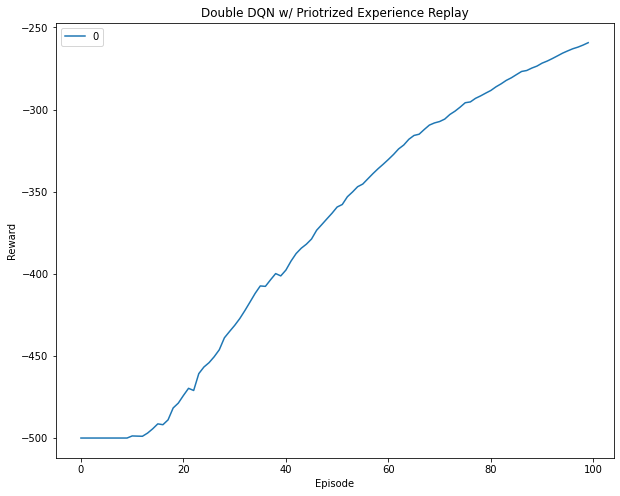

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for n, ep_rewards in enumerate(run_rewards):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards)
    avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
    plt.figure(figsize=(10,8))
    plt.plot(x, avgs, label=n)

plt.title("Double DQN w/ Priotrized Experience Replay")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()


In [ ]:
num_runs = 2
run_rewards = []

for n in range(num_runs):
    print("Run {}".format(n))
    ep_rewards = []
    agent = None
    agent = DoubleDQNAgent(env)
    num_episodes = 100

    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.train(state, action, next_state, reward, done, a=0.7, use_DDQN=(n%2==0))
            env.render()
            total_reward += reward
            state = next_state

        ep_rewards.append(total_reward)
        print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))

    run_rewards.append(ep_rewards)


Run 0


<ipython-input-5-b4d7a37aec8f>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(self.buffer)[sample_indices]


Episode: 0, total_reward: -500.00
Episode: 1, total_reward: -500.00
Episode: 2, total_reward: -500.00
Episode: 3, total_reward: -500.00
Episode: 4, total_reward: -500.00
Episode: 5, total_reward: -500.00
Episode: 6, total_reward: -500.00
Episode: 7, total_reward: -499.00
Episode: 8, total_reward: -500.00
Episode: 9, total_reward: -500.00
Episode: 10, total_reward: -437.00
Episode: 11, total_reward: -500.00
Episode: 12, total_reward: -500.00
Episode: 13, total_reward: -500.00
Episode: 14, total_reward: -500.00
Episode: 15, total_reward: -500.00
Episode: 16, total_reward: -335.00
Episode: 17, total_reward: -345.00
Episode: 18, total_reward: -500.00
Episode: 19, total_reward: -320.00
Episode: 20, total_reward: -327.00
Episode: 21, total_reward: -404.00
Episode: 22, total_reward: -427.00
Episode: 23, total_reward: -228.00
Episode: 24, total_reward: -349.00
Episode: 25, total_reward: -248.00
Episode: 26, total_reward: -421.00
Episode: 27, total_reward: -500.00
Episode: 28, total_reward: -33

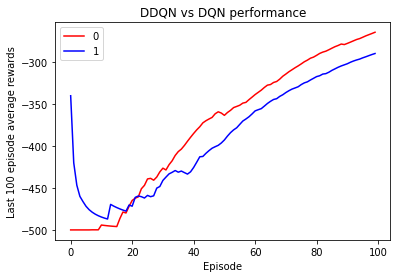

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for n, ep_rewards in enumerate(run_rewards):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards)
    avgs = [cumsum[ep]/(ep+1) if ep<100 else (cumsum[ep]-cumsum[ep-100])/100 for ep in x]
    col = "r" if (n%2==0) else "b"
    plt.plot(x, avgs, color=col, label=n)

plt.title("DDQN vs DQN performance")
plt.xlabel("Episode")
plt.ylabel("Last 100 episode average rewards")
plt.legend()



In [ ]:
env.close()